# YOLOv1RESNET_VEHICLES DATASET
*Caminiti Giovanni, Farolfi Eleonora*

Dataset used:
https://public.roboflow.com/object-detection/vehicles-openimages/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import random
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

import json
import os
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

from torch import nn
from torch.nn import functional as F

import numpy as np
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

#HYPERPARAMETERS


In [3]:
from pathlib import Path
import os

# --- Detect Colab ---
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# --- Path selection ---
if IN_COLAB:
    DATA_PATH = Path("/content/drive/MyDrive/Vehicles-OpenImages.v1-416x416.coco")
else:
    # GitHub / local repo
    DATA_PATH = Path("data/Vehicles-OpenImages.v1-416x416.coco")

CLASSES_PATH = DATA_PATH / "classes.json"

print("Using DATA_PATH =", DATA_PATH)

# --- Hyperparameters ---
BATCH_SIZE = 32
EPOCHS = 50
WARMUP_EPOCHS = 0
LEARNING_RATE = 1e-4

EPSILON = 1e-6
IMAGE_SIZE = (416, 416)

S = 7
B = 2
C = 5

NUM_WORKERS = min(4, os.cpu_count() or 1)

Using DATA_PATH = /content/drive/MyDrive/Vehicles-OpenImages.v1-416x416.coco


## 🔧 Auxiliary Functions

In [4]:
def get_iou(p, a):
    """
    Compute the Intersection-over-Union (IoU) between two sets of bounding boxes.
    """
    p_tl, p_br = bbox_to_coords(p)   # (batch, S, S, B, 2)
    a_tl, a_br = bbox_to_coords(a)

    coords_join_size = (-1, -1, -1, B, B, 2)

    tl = torch.max(
        p_tl.unsqueeze(4).expand(coords_join_size),
        a_tl.unsqueeze(3).expand(coords_join_size)
    )
    br = torch.min(
        p_br.unsqueeze(4).expand(coords_join_size),
        a_br.unsqueeze(3).expand(coords_join_size)
    )

    intersection_sides = torch.clamp(br - tl, min=0.0)
    intersection = intersection_sides[..., 0] * intersection_sides[..., 1]  # (batch, S, S, B, B)

    p_area = (bbox_attr(p, 2) * bbox_attr(p, 3)).unsqueeze(4).expand_as(intersection)
    a_area = (bbox_attr(a, 2) * bbox_attr(a, 3)).unsqueeze(3).expand_as(intersection)

    union = p_area + a_area - intersection

    # Avoid division by zero
    zero_union_mask = (union == 0.0)
    union = union.masked_fill(zero_union_mask, EPSILON)
    intersection = intersection.masked_fill(zero_union_mask, 0.0)

    return intersection / union


def bbox_to_coords(t):
    """
    Convert bounding boxes from [x_center, y_center, width, height]
    to top-left and bottom-right coordinates.
    """
    width = bbox_attr(t, 2)
    height = bbox_attr(t, 3)

    x = bbox_attr(t, 0)
    y = bbox_attr(t, 1)

    x1 = x - width / 2.0
    y1 = y - height / 2.0

    x2 = x + width / 2.0
    y2 = y + height / 2.0

    return torch.stack((x1, y1), dim=4), torch.stack((x2, y2), dim=4)


def scheduler_lambda(epoch):
    """
    Learning rate scheduler following YOLOv1 step decay.
    """
    if epoch < WARMUP_EPOCHS + 75:
        return 1
    elif epoch < WARMUP_EPOCHS + 105:
        return 0.1
    else:
        return 0.01


def bbox_attr(data, i):
    """
    Return the i-th bounding box attribute for all cells.
    """
    attr_start = C + i
    return data[..., attr_start::5]


def get_overlap(a, b):
    """
    Compute overlap between two boxes (top-left, width, height).
    Used for simple NMS in the `plot_boxes` function.
    """
    a_tl, a_w, a_h, _, _ = a
    b_tl, b_w, b_h, _, _ = b

    i_tl = (max(a_tl[0], b_tl[0]), max(a_tl[1], b_tl[1]))
    i_br = (min(a_tl[0] + a_w, b_tl[0] + b_w),
            min(a_tl[1] + a_h, b_tl[1] + b_h))

    intersection = max(0, i_br[0] - i_tl[0]) * max(0, i_br[1] - i_tl[1])

    a_area = a_w * a_h
    b_area = b_w * b_h

    if a_area == 0:
        a_area = EPSILON
        a_intersection = 0
    else:
        a_intersection = intersection

    if b_area == 0:
        b_area = EPSILON
        b_intersection = 0
    else:
        b_intersection = intersection

    return max(a_intersection / a_area, b_intersection / b_area)


def plot_boxes(data, labels, classes, color='orange',
               min_confidence=0.2, max_overlap=0.5, file=None):
    """
    Plot predicted bounding boxes on an image.
    If `file` is provided, the image is saved to disk.
    """
    grid_size_x = data.size(2) / S
    grid_size_y = data.size(1) / S

    bboxes = []
    m, n = labels.size(0), labels.size(1)

    for i in range(m):
        for j in range(n):
            for k in range((labels.size(2) - C) // 5):
                bbox_start = 5 * k + C
                bbox = labels[i, j, bbox_start:bbox_start + 5]

                class_index = torch.argmax(labels[i, j, :C]).item()
                conf = labels[i, j, class_index].item() * bbox[4].item()

                if conf > min_confidence:
                    width = bbox[2] * IMAGE_SIZE[0]
                    height = bbox[3] * IMAGE_SIZE[1]

                    tl = (bbox[0] * IMAGE_SIZE[0] + j * grid_size_x - width / 2,
                          bbox[1] * IMAGE_SIZE[1] + i * grid_size_y - height / 2)

                    bboxes.append([tl, width, height, conf, class_index])

    # Sort by confidence
    bboxes = sorted(bboxes, key=lambda x: x[3], reverse=True)

    # Build IoU matrix for simple NMS
    num_boxes = len(bboxes)
    iou = [[get_overlap(bboxes[i], bboxes[j]) for j in range(num_boxes)]
           for i in range(num_boxes)]

    image = T.ToPILImage()(data)
    draw = ImageDraw.Draw(image)
    discarded = set()

    for i in range(num_boxes):
        if i in discarded:
            continue
        tl, w, h, conf, cls = bboxes[i]

        for j in range(num_boxes):
            if j != i and bboxes[j][4] == cls and iou[i][j] > max_overlap:
                discarded.add(j)

        draw.rectangle((tl, (tl[0] + w, tl[1] + h)), outline=color)
        text = f"{classes[cls]} {round(conf * 100, 1)}%"

        text_pos = (max(0, tl[0]), max(0, tl[1] - 12))
        text_bbox = draw.textbbox(text_pos, text)

        draw.rectangle(text_bbox, fill=color)
        draw.text(text_pos, text, fill="black")

    if file is None:
        display(image)
    else:
        os.makedirs(os.path.dirname(file), exist_ok=True)
        if not file.endswith('.png'):
            file += '.png'
        image.save(file)

In [5]:
class YoloVehiclesCocoDataset(Dataset):
    """
    Custom dataset class for the Vehicles-OpenImages COCO subset.
    Converts COCO annotations into YOLOv1 grid format (S x S x (C + 5B)).
    """

    def __init__(self, set_type, normalize=False, augment=False):
        """
        Args:
            set_type (str): One of {'train', 'test', 'valid'}.
            normalize (bool): Apply ImageNet normalization.
            augment (bool): Apply affine and color augmentations.
        """
        assert set_type in {'train', 'test', 'valid'}

        self.set_type = set_type
        self.normalize = normalize
        self.augment = augment

        self.images_dir = os.path.join(DATA_PATH, set_type)
        ann_file = os.path.join(DATA_PATH, set_type, "_annotations.coco.json")

        with open(ann_file, "r") as f:
            coco_data = json.load(f)

        self.images_info = coco_data["images"]
        self.annotations = coco_data["annotations"]
        self.categories = coco_data["categories"]

        # Build image_id → annotations list
        self.img_id_to_anns = {}
        for ann in self.annotations:
            img_id = ann["image_id"]
            self.img_id_to_anns.setdefault(img_id, []).append(ann)

        # COCO categories → names
        self.cat_id_to_name = {cat["id"]: cat["name"] for cat in self.categories}

        # Filter in only vehicle classes
        self.vehicle_classes = ['car', 'bus', 'motorcycle', 'ambulance', 'truck']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.vehicle_classes)}

        # Remove missing images
        filtered_images = []
        for img in self.images_info:
            img_path = os.path.join(self.images_dir, img["file_name"])
            if os.path.exists(img_path):
                filtered_images.append(img)

        self.images_info = filtered_images

        # Transforms
        self.transform = T.Compose([
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.images_info)

    def __getitem__(self, idx):
        img_info = self.images_info[idx]
        img_path = os.path.join(self.images_dir, img_info["file_name"])

        image = Image.open(img_path).convert("RGB")
        original_image = image.copy()

        orig_width = img_info["width"]
        orig_height = img_info["height"]

        # Standard resize
        image = image.resize(IMAGE_SIZE)
        data = self.transform(image)

        # Random affine augmentation parameters
        x_shift = int((0.2 * random.random() - 0.1) * IMAGE_SIZE[0])
        y_shift = int((0.2 * random.random() - 0.1) * IMAGE_SIZE[1])
        scale_factor = 1 + 0.2 * random.random()

        # Apply augmentations
        if self.augment:
            data = TF.affine(data, angle=0.0, translate=(x_shift, y_shift),
                             scale=scale_factor, shear=0.0)
            data = TF.adjust_hue(data, 0.2 * random.random() - 0.1)
            data = TF.adjust_saturation(data, 0.2 * random.random() + 0.9)

        if self.normalize:
            data = TF.normalize(
                data,
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )

        # Compute YOLO grid
        grid_size_x = IMAGE_SIZE[0] / S
        grid_size_y = IMAGE_SIZE[1] / S

        depth = 5 * B + C
        ground_truth = torch.zeros((S, S, depth))
        boxes = {}
        class_names = {}

        anns = self.img_id_to_anns.get(img_info["id"], [])
        for ann in anns:
            cat_name = self.cat_id_to_name[ann["category_id"]].lower()

            if cat_name not in self.vehicle_classes:
                continue

            class_index = self.class_to_idx[cat_name]
            x_min, y_min, w, h = ann["bbox"]

            x_max = x_min + w
            y_max = y_min + h

            # Scale COCO bbox to resized image
            scale_x = IMAGE_SIZE[0] / orig_width
            scale_y = IMAGE_SIZE[1] / orig_height

            x_min *= scale_x
            x_max *= scale_x
            y_min *= scale_y
            y_max *= scale_y

            # Apply augmentation to bbox
            if self.augment:
                half_w = IMAGE_SIZE[0] / 2
                half_h = IMAGE_SIZE[1] / 2

                x_min = scale_bbox_coord(x_min, half_w, scale_factor) + x_shift
                x_max = scale_bbox_coord(x_max, half_w, scale_factor) + x_shift
                y_min = scale_bbox_coord(y_min, half_h, scale_factor) + y_shift
                y_max = scale_bbox_coord(y_max, half_h, scale_factor) + y_shift

            # Convert bbox to YOLO cell
            mid_x = (x_min + x_max) / 2
            mid_y = (y_min + y_max) / 2

            col = int(mid_x // grid_size_x)
            row = int(mid_y // grid_size_y)

            if 0 <= col < S and 0 <= row < S:

                cell = (row, col)

                # Set class one-hot
                if cell not in class_names or cat_name == class_names[cell]:
                    one_hot = torch.zeros(C)
                    one_hot[class_index] = 1.0

                    ground_truth[row, col, :C] = one_hot
                    class_names[cell] = cat_name

                    bbox_index = boxes.get(cell, 0)

                    if bbox_index < B:
                        bbox_norm = (
                            (mid_x - col * grid_size_x) / IMAGE_SIZE[0],
                            (mid_y - row * grid_size_y) / IMAGE_SIZE[1],
                            (x_max - x_min) / IMAGE_SIZE[0],
                            (y_max - y_min) / IMAGE_SIZE[1],
                            1.0
                        )

                        bbox_start = 5 * bbox_index + C
                        ground_truth[row, col, bbox_start:] = (
                            torch.tensor(bbox_norm).repeat(B - bbox_index)
                        )

                        boxes[cell] = bbox_index + 1

        original_data = T.ToTensor()(original_image.resize(IMAGE_SIZE))
        return data, ground_truth, original_data


def scale_bbox_coord(coord, center, scale):
    """Scale bbox coordinate around a center point."""
    return ((coord - center) * scale) + center

# Dataset Demo / Sanity Check

🔍 Loading training subset for inspection...

Number of images in the dataset: 878

🔎 Displaying two sample images with bounding boxes:

🖼️ Example #1


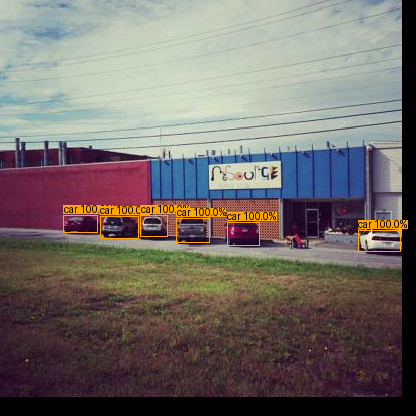

 - Image tensor shape:      torch.Size([3, 416, 416])
 - Label tensor shape:      torch.Size([7, 7, 15])
 - Original resized shape:  torch.Size([3, 416, 416])
 - Non-zero label indices:  tensor([[ 3,  1,  0],
        [ 3,  1,  5],
        [ 3,  1,  6],
        [ 3,  1,  7],
        [ 3,  1,  8],
        [ 3,  1,  9],
        [ 3,  1, 10],
        [ 3,  1, 11],
        [ 3,  1, 12],
        [ 3,  1, 13],
        [ 3,  1, 14],
        [ 3,  2,  0],
        [ 3,  2,  5],
        [ 3,  2,  6],
        [ 3,  2,  7],
        [ 3,  2,  8],
        [ 3,  2,  9],
        [ 3,  2, 10],
        [ 3,  2, 11],
        [ 3,  2, 12],
        [ 3,  2, 13],
        [ 3,  2, 14],
        [ 3,  3,  0],
        [ 3,  3,  5],
        [ 3,  3,  6],
        [ 3,  3,  7],
        [ 3,  3,  8],
        [ 3,  3,  9],
        [ 3,  3, 10],
        [ 3,  3, 11],
        [ 3,  3, 12],
        [ 3,  3, 13],
        [ 3,  3, 14],
        [ 3,  4,  0],
        [ 3,  4,  5],
        [ 3,  4,  6],
        [ 3,  4,  7],

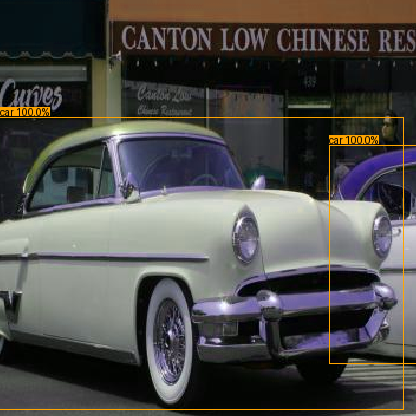

 - Image tensor shape:      torch.Size([3, 416, 416])
 - Label tensor shape:      torch.Size([7, 7, 15])
 - Original resized shape:  torch.Size([3, 416, 416])
 - Non-zero label indices:  tensor([[ 4,  2,  0],
        [ 4,  2,  5],
        [ 4,  2,  6],
        [ 4,  2,  7],
        [ 4,  2,  8],
        [ 4,  2,  9],
        [ 4,  2, 10],
        [ 4,  2, 11],
        [ 4,  2, 12],
        [ 4,  2, 13],
        [ 4,  2, 14],
        [ 4,  6,  0],
        [ 4,  6,  5],
        [ 4,  6,  6],
        [ 4,  6,  7],
        [ 4,  6,  8],
        [ 4,  6,  9],
        [ 4,  6, 10],
        [ 4,  6, 11],
        [ 4,  6, 12],
        [ 4,  6, 13],
        [ 4,  6, 14]])

Total negative labels found: 0
Image intensity range: min=0.0, max=1.0

Object classes: ['car', 'bus', 'motorcycle', 'ambulance', 'truck']
Sample label row [1,3]: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Sample label row [3,3]: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [6]:
print("🔍 Loading training subset for inspection...\n")

# Load a small subset for visual sanity check
demo_set = YoloVehiclesCocoDataset('train', normalize=False, augment=True)
print(f"Number of images in the dataset: {len(demo_set)}")

obj_classes = demo_set.vehicle_classes

negative_labels = 0
smallest = float('inf')
largest = float('-inf')
example_count = 0

print("\n🔎 Displaying two sample images with bounding boxes:\n")

for example, label, original_data in demo_set:
    example_count += 1

    negative_labels += torch.sum(label < 0).item()
    smallest = min(smallest, torch.min(example).item())
    largest = max(largest, torch.max(example).item())

    print(f"🖼️ Example #{example_count}")
    plot_boxes(example, label, obj_classes, max_overlap=float('inf'))

    print(f" - Image tensor shape:      {example.shape}")
    print(f" - Label tensor shape:      {label.shape}")
    print(f" - Original resized shape:  {original_data.shape}")
    print(f" - Non-zero label indices:  {torch.nonzero(label)}\n")

    if example_count >= 2:   # limit inspection to two samples
        break

print(f"Total negative labels found: {negative_labels}")
print(f"Image intensity range: min={smallest}, max={largest}")

print("\nObject classes:", obj_classes)
print("Sample label row [1,3]:", label[1, 3, 0 : 5 * B + C])
print("Sample label row [3,3]:", label[3, 3, 0 : 5 * B + C])

#YOLOv1 Loss (Sum-Squared Error)

In [7]:
class SumSquaredErrorLoss(nn.Module):
    """
    YOLOv1 loss function, composed of:
    - Coordinate loss (x, y, w, h)
    - Object confidence loss
    - No-object confidence loss
    - Classification loss
    """

    def __init__(self):
        super().__init__()
        self.l_coord = 5.0    # weight for localization loss
        self.l_noobj = 0.5    # weight for background loss

    def forward(self, p, a):
        """
        Args:
            p (Tensor): predictions (batch, S, S, C + 5B)
            a (Tensor): ground truth (batch, S, S, C + 5B)

        Returns:
            Tensor: loss value
        """
        # Compute IoU for responsibility assignment
        iou = get_iou(p, a)                 # (batch, S, S, B, B)
        max_iou = torch.max(iou, dim=-1)[0] # (batch, S, S, B)

        # Mask: which cells contain an object
        bbox_mask = bbox_attr(a, 4) > 0.0
        obj_i = bbox_mask[..., 0:1]         # (batch, S, S, 1)

        # Template for B bounding boxes
        p_template = bbox_attr(p, 4) > 0.0

        # Determine responsible bounding box (highest IoU)
        responsible = torch.zeros_like(p_template).scatter_(
            -1,
            torch.argmax(max_iou, dim=-1, keepdim=True),
            value=1
        )

        obj_ij = obj_i * responsible
        noobj_ij = ~obj_ij

        # ---------------------------
        # 1. Coordinate losses (x, y)
        # ---------------------------
        x_loss = mse_loss(obj_ij * bbox_attr(p, 0),
                          obj_ij * bbox_attr(a, 0))

        y_loss = mse_loss(obj_ij * bbox_attr(p, 1),
                          obj_ij * bbox_attr(a, 1))

        pos_losses = x_loss + y_loss

        # ---------------------------
        # 2. Dimension losses (w, h) with sqrt transform
        # ---------------------------
        p_w = bbox_attr(p, 2)
        a_w = bbox_attr(a, 2)

        width_loss = mse_loss(
            obj_ij * torch.sign(p_w) * torch.sqrt(torch.abs(p_w) + EPSILON),
            obj_ij * torch.sqrt(a_w)
        )

        p_h = bbox_attr(p, 3)
        a_h = bbox_attr(a, 3)

        height_loss = mse_loss(
            obj_ij * torch.sign(p_h) * torch.sqrt(torch.abs(p_h) + EPSILON),
            obj_ij * torch.sqrt(a_h)
        )

        dim_losses = width_loss + height_loss

        # ---------------------------
        # 3. Confidence losses
        # ---------------------------
        obj_conf_loss = mse_loss(
            obj_ij * bbox_attr(p, 4),
            obj_ij * torch.ones_like(max_iou)
        )

        noobj_conf_loss = mse_loss(
            noobj_ij * bbox_attr(p, 4),
            torch.zeros_like(max_iou)
        )

        # ---------------------------
        # 4. Class loss (one-hot)
        # ---------------------------
        class_loss = mse_loss(
            obj_i * p[..., :C],
            obj_i * a[..., :C]
        )

        # ---------------------------
        # Final weighted YOLOv1 loss
        # ---------------------------
        total = (
            self.l_coord * (pos_losses + dim_losses) +
            obj_conf_loss +
            self.l_noobj * noobj_conf_loss +
            class_loss
        )

        return total / BATCH_SIZE


# -------------------------------------
# MSE Loss helper (sum over all cells)
# -------------------------------------
def mse_loss(a, b):
    """
    Flatten all grid cells and sum the squared error.
    """
    a_flat = torch.flatten(a, end_dim=-2)
    b_flat = torch.flatten(b, end_dim=-2).expand_as(a_flat)

    return F.mse_loss(a_flat, b_flat, reduction="sum")

# Transfer Learning: Use a pre-trained ResNet as backbone network

In [8]:
from torchvision.models import resnet50, ResNet50_Weights

#################################
#       Transfer Learning       #
#  Use a pre-trained ResNet as  #
#  backbone network             #
#################################
class YOLOv1ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.depth = B * 5 + C

        # Load backbone ResNet pretrained on ImageNet-1K
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        # Freeze parameters of backbone network for TRANSFER LEARNING by setting
        # "no need for gradient information" on those paramters
        backbone.requires_grad_(False)

        # Delete last two layers (setting to identity function suits the case)
        # and attach detection layers
        backbone.avgpool = nn.Identity()
        backbone.fc = nn.Identity()
        self.model = nn.Sequential(
            backbone,
            Reshape(2048, 13, 13),
            DetectionNet(2048)   # 4 convolutional + 2 linear layers, as below
        )

    def forward(self, x):
        return self.model.forward(x)


class DetectionNet(nn.Module):
    """The layers added on for detection as described in YOLO paper.
    4 convolutions layers + 2 FC layers with LeakyReLU activation function"""

    def __init__(self, in_channels):
        super().__init__()

        inner_channels = 1024
        self.depth = 5 * B + C
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, stride=2, padding=1),   # (#channels*14*14) -> (#channels*7*7)
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Flatten(),
            nn.Linear(7 * 7 * inner_channels, 4096),
            # nn.Dropout(),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(4096, S * S * self.depth)  # output: S*S*(5B+C)
        )

    def forward(self, x):
        return torch.reshape(
            self.model.forward(x),
            (-1, S, S, self.depth)
        )

#############################
#       Helper Modules      #
#############################
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = tuple(args)

    def forward(self, x):
        return torch.reshape(x, (-1, *self.shape))

# Dataset Setup
## Train and Test Sets
## Train and Test DataLoaders

In [9]:
train_set = YoloVehiclesCocoDataset('train', normalize=True, augment=True)
test_set  = YoloVehiclesCocoDataset('test',  normalize=True, augment=True)

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    drop_last=True,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    drop_last=True
)

# Model Initialization (Transfer Learning with ResNet50)

# YOLOv1 Loss Function Definition

# Optimizer Setup (Adam)


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.autograd.set_detect_anomaly(True)
writer = SummaryWriter()
now = datetime.now()

model = YOLOv1ResNet().to(device)

loss_function = SumSquaredErrorLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


In [11]:
root = os.path.join(
    'models',
    'yolo_v1',
    now.strftime('%m_%d_%Y'),
    now.strftime('%H_%M_%S')
)
weight_dir = os.path.join(root, 'weights')
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

# Containers for metrics
train_losses = np.empty((2, 0))
test_losses  = np.empty((2, 0))
train_errors = np.empty((2, 0))
test_errors  = np.empty((2, 0))

def save_metrics():
    np.save(os.path.join(root, 'train_losses.npy'), train_losses)
    np.save(os.path.join(root, 'test_losses.npy'), test_losses)
    np.save(os.path.join(root, 'train_errors.npy'), train_errors)
    np.save(os.path.join(root, 'test_errors.npy'), test_errors)

#Training (50 epochs)

In [12]:
for epoch in tqdm(range(WARMUP_EPOCHS + EPOCHS), desc='Epoch'):
    # --------------------
    # TRAIN
    # --------------------
    model.train()
    train_loss = 0.0
    for data, labels, _ in tqdm(train_loader, desc='Train', leave=False):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(data)
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() / len(train_loader)
        del data, labels

    train_losses = np.append(train_losses, [[epoch], [train_loss]], axis=1)
    writer.add_scalar('Loss/train', train_loss, epoch)

    if epoch % 4 == 0:
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            for data, labels, _ in tqdm(test_loader, desc='Test', leave=False):
                data = data.to(device)
                labels = labels.to(device)

                predictions = model(data)
                loss = loss_function(predictions, labels)

                test_loss += loss.item() / len(test_loader)
                del data, labels
        test_losses = np.append(test_losses, [[epoch], [test_loss]], axis=1)
        writer.add_scalar('Loss/test', test_loss, epoch)
        save_metrics()

save_metrics()
torch.save(model.state_dict(), os.path.join(weight_dir, 'final'))

Train: 100%|██████████| 27/27 [03:04<00:00,  7.01s/it]
                                                      
Train: 100%|██████████| 27/27 [00:37<00:00,  1.17s/it]
                                                      
Train: 100%|██████████| 27/27 [00:39<00:00,  1.22s/it]
                                                      
Train: 100%|██████████| 27/27 [00:38<00:00,  1.16s/it]
                                                      
Train: 100%|██████████| 27/27 [00:39<00:00,  1.21s/it]
                                                      
Train: 100%|██████████| 27/27 [00:37<00:00,  1.18s/it]
                                                      
Train: 100%|██████████| 27/27 [00:38<00:00,  1.22s/it]
                                                      
Train: 100%|██████████| 27/27 [00:37<00:00,  1.12s/it]
                                                      
Train: 100%|██████████| 27/27 [00:38<00:00,  1.21s/it]
                                                      
Train: 100

#SAVE FINAL WEIGHTS

In [14]:
# Save metrics one last time
save_metrics()

# Path where training loop saved weights
final_local_path = os.path.join(weight_dir, "final.pth")

torch.save(model.state_dict(), final_local_path)
print("✅ Final weights saved to:", final_local_path)

# ============================================================
#   OPTIONAL (COLAB ONLY): COPY WEIGHTS TO GOOGLE DRIVE
# ============================================================

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from pathlib import Path
    import shutil

    final_drive_path = Path("/content/drive/MyDrive/YoloResnet_model.pth")
    shutil.copy(final_local_path, final_drive_path)
    print("📁 Copied weights to Google Drive:", final_drive_path)
else:
    final_drive_path = None

# ============================================================
#   LOAD WEIGHTS (COLAB + GITHUB COMPATIBLE)
# ============================================================

# If in Colab → load from Drive
# If on GitHub → load from repo (models/YoloResnet_model.pth)
if IN_COLAB:
    WEIGHTS_PATH = final_drive_path
else:
    WEIGHTS_PATH = Path("models/YoloResnet_model.pth")

# Safety check
if WEIGHTS_PATH is None or not Path(WEIGHTS_PATH).exists():
    raise FileNotFoundError(
        f"❌ Weights not found. Expected at: {WEIGHTS_PATH}\n"
        "Make sure to copy them to Google Drive (Colab) or place them in models/ (GitHub)."
    )

# Load state dict
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))
model.to(device)
model.eval()

print("✅ Loaded pretrained YOLOv1-ResNet model from:", WEIGHTS_PATH)

✅ Final weights saved to: models/yolo_v1/11_23_2025/19_18_45/weights/final.pth
📁 Copied weights to Google Drive: /content/drive/MyDrive/YoloResnet_model.pth
✅ Loaded pretrained YOLOv1-ResNet model from: /content/drive/MyDrive/YoloResnet_model.pth


# Inference on Test Images

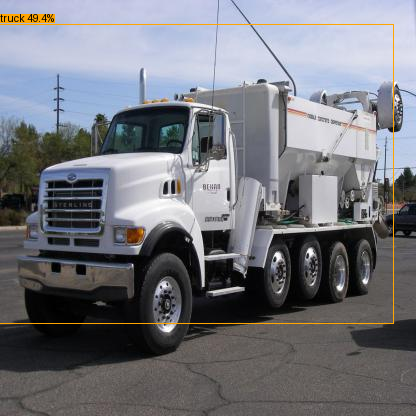

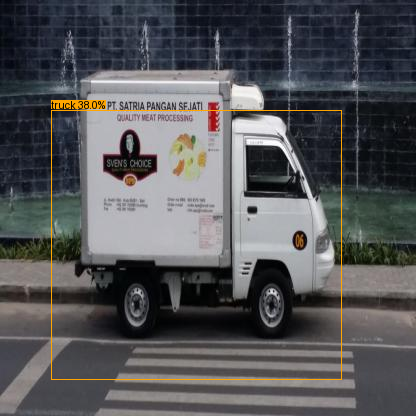

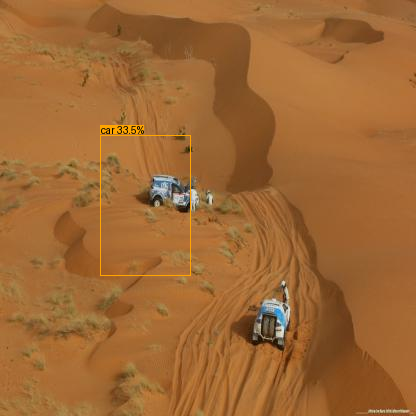

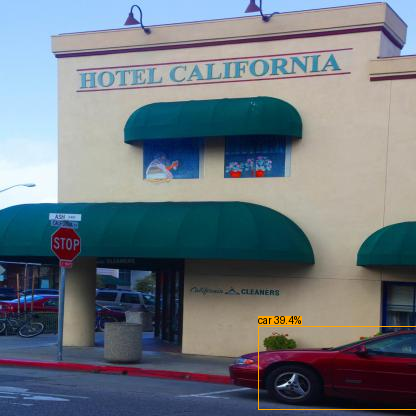

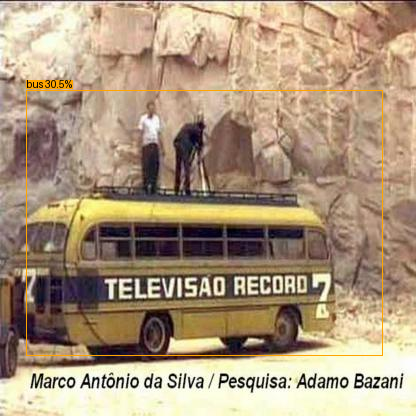

In [18]:
import os
from tqdm import tqdm
from IPython.display import display

model.eval()
num_images_to_show = 5
image_count = 0

with torch.no_grad():
    for batch_idx, (images, labels, originals) in enumerate(test_loader):
        images = images.to(device)
        predictions = model(images)

        for i in range(images.shape[0]):
            if image_count >= num_images_to_show:
                break

            plot_boxes(
                originals[i],
                predictions[i],
                obj_classes
            )
            image_count += 1

        if image_count >= num_images_to_show:
            break

## One last test with a picture of me and my car, Sofia :)

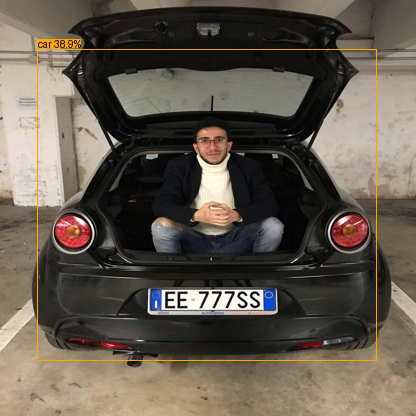

In [19]:
import os
from PIL import Image
import torchvision.transforms as T
from IPython.display import display
import torch

img_path = '/content/drive/MyDrive/test_auto2.jpg'

image = Image.open(img_path).convert('RGB')

image_resized = image.resize(IMAGE_SIZE)

transform = T.ToTensor()
image_tensor = transform(image_resized)

normalize_transform = T.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
image_tensor_normalized = normalize_transform(image_tensor)

input_tensor = image_tensor_normalized.unsqueeze(0).to(device)

def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

model.eval()
with torch.no_grad():
    prediction = model(input_tensor)

prediction = prediction[0]

image_tensor_denorm = denormalize_image(image_tensor_normalized.cpu())

plot_boxes(image_tensor_denorm, prediction.cpu(), obj_classes)

# Confusion Matrix

Building Confusion Matrix: 100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


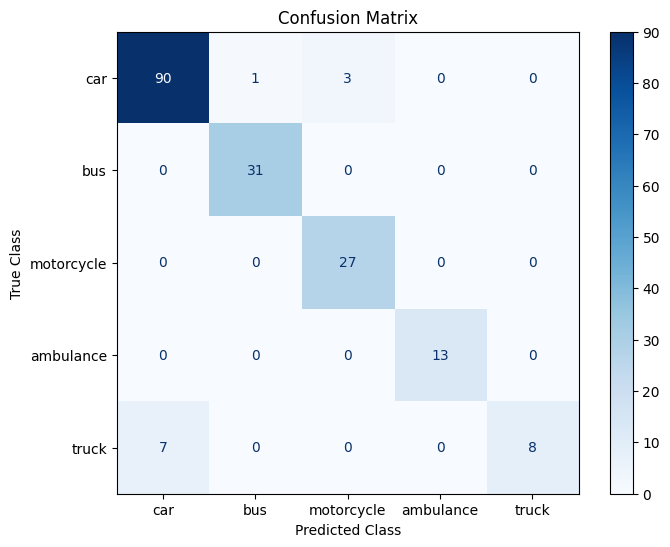

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for images, labels, originals in tqdm(test_loader, desc="Building Confusion Matrix"):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)

        batch_size = images.size(0)

        for b in range(batch_size):
            for i in range(S):
                for j in range(S):
                    gt_cell = labels[b, i, j, :C]

                    # consider only cells containing an object
                    if gt_cell.sum() > 0:
                        true_class = torch.argmax(gt_cell).item()
                        pred_class = torch.argmax(predictions[b, i, j, :C]).item()

                        true_labels.append(true_class)
                        pred_labels.append(pred_class)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(C)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=obj_classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=True)

ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
plt.show()


# Classification Metrics


In [24]:
from sklearn.metrics import classification_report, accuracy_score

if not true_labels or not pred_labels:
    print("No valid labels found. Check dataset and predictions.")
else:
    # overall accuracy
    acc = accuracy_score(true_labels, pred_labels)
    print(f"Accuracy (cell-level): {acc:.4f}\n")

    # per-class precision/recall/f1
    print(
        classification_report(
            true_labels,
            pred_labels,
            labels=list(range(C)),
            target_names=obj_classes,
            zero_division=0
        )
    )


Accuracy (cell-level): 0.9389

              precision    recall  f1-score   support

         car       0.93      0.96      0.94        94
         bus       0.97      1.00      0.98        31
  motorcycle       0.90      1.00      0.95        27
   ambulance       1.00      1.00      1.00        13
       truck       1.00      0.53      0.70        15

    accuracy                           0.94       180
   macro avg       0.96      0.90      0.91       180
weighted avg       0.94      0.94      0.93       180

